In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Crear datasets
from sklearn.datasets import make_regression

Vamos a crear un dataset sintetico utilizando las librerias de [Sklearn Datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html), en particular nos interesa crear un problema de regresion
lineal al que podemos variarle sus parametros

In [48]:
# Creamos un dataset de prueba
X, y = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 2,
                       n_informative = 1,
                       random_state = 42)

new_data = np.append(X,y.reshape(-1,1),axis=1)
new_data.shape

(1000, 2)

In [49]:
df = pd.DataFrame(new_data)

new_col = []
i = 0
for col in df.columns:
    if i ==  len(df.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df.columns = new_col

df.head()

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314


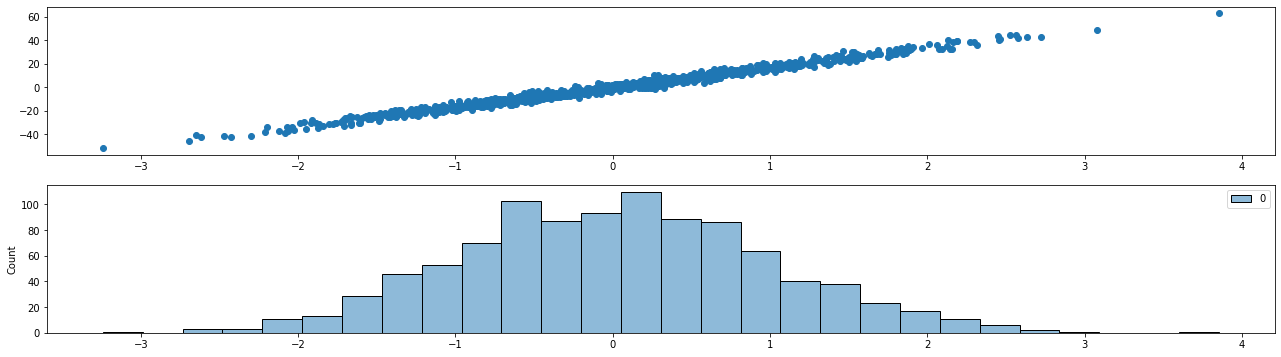

In [50]:
fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X,y)
sns.histplot(X, ax=axes[1]);

## Funciones auxiliares para generar datos anómalos

In [51]:
def generate_nulls(df: pd.DataFrame,
                   cols: list = None,
                   percentage: float = 0.05) -> pd.DataFrame:
  """Con esta función vamos a poder generar nulos en ciertas columnas de nuestro
  dataset.
  """  
  cols = df.columns.tolist() if cols is None else cols
  seeds = np.random.randint(100, size = len(cols))
  
  nsamples = np.math.floor(len(df) * percentage)

  result = df.copy(deep = True)
  for i,col_name in enumerate(cols):
      np.random.seed(seeds[i])
      
      idx_to_remove = result[col_name].sample(n = nsamples).index
      result[col_name].iloc[idx_to_remove] = np.nan if result[col_name].dtype in [int,float] else None
  
  return result

def generate_outliers(df: pd.DataFrame,
                     cols: list = None,
                     extreme_outlier: bool = False,
                     percentage: float = 0.02) -> pd.DataFrame:
  """Con esta función vamos a poder generar outliers en ciertas columnas de nuestro
  dataset. Si le damos True a _extreme_outlier_ va a generar outliers con mucho
  peso en la regresión
  """  
  seeds = np.random.randint(100, size = len(df))
  
  nsamples = np.math.floor(len(df) * percentage)
  idx_to_change = df.sample(n = nsamples).index

  cols = df.columns.tolist() if cols is None else cols

  result = df.copy(deep = True)
  
  for i,col_name in enumerate(cols):
    np.random.seed(seeds[i])

    if extreme_outlier:
      iqr = result[col_name].quantile(0.75) - result[col_name].quantile(0.25)
      max_val = 3*iqr
      outlier_sign = [1 if np.random.random() < 0.5 else -1 for _ in range(nsamples)]
      outliers = np.multiply(outlier_sign, np.random.uniform(low = iqr,
                                                          high = max_val,
                                                          size = nsamples))
      
      result[col_name].loc[idx_to_change] = outliers
    else:
      samples = result[col_name].loc[idx_to_change].values
      np.random.shuffle(samples)
      result[col_name].iloc[idx_to_change] = samples
  return result

In [52]:
df_outlier = generate_outliers(df,['target'], percentage = 0.01, extreme_outlier = True)

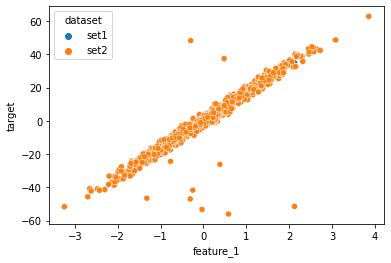

In [53]:
sns.scatterplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_outlier.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

In [54]:
columnas_a_modificar = ['feature_1'] 
df_missing = generate_nulls(df,columnas_a_modificar, percentage = 0.01)

In [55]:
df_missing.isna().sum()

feature_1    10
target        0
dtype: int64

# Primera Parte

## Ejercicio 1

Crear una función que separe los datos en train-validation-test 70-20-10


Hints: 

* Usar Indexing y slicing
* Usar np.random.[...]

In [56]:
def split(df: pd.DataFrame, train_size: float,random_state: int):
    df=df.sample(frac=1,random_state=random_state).reset_index()
    size=len(df)
    #print(size)
    train_len=int(size*train_size)
    #print(train_len)
    train_df=df.iloc[:train_len]
    val_len=train_len+int((1-train_size)*0.67*size)
    #print(val_len)
    val_df=df.iloc[train_len:val_len]
    test_df=df.iloc[val_len:size]
    X_train=train_df.iloc[:,0]
    Y_train=train_df.iloc[:,1]
    X_val=val_df.iloc[:,0]
    Y_val=val_df.iloc[:,1]
    X_test=test_df.iloc[:,0]
    Y_test=test_df.iloc[:,1]
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [57]:
from sklearn.model_selection import train_test_split

X_train,X_test, Y_train, Y_test = train_test_split(df.feature_1,
                                                   df.target,
                                                   test_size = 0.3)

X_val, X_test, Y_val, Y_test = train_test_split(X_test,
                                               Y_test,
                                               train_size = 0.66)

## Ejercicio 2

Utilizando la funcion `generate_nulls`. Insertar en la columna de features un 5% de valores nulos. Con esto, generar una función que les permita rellenar estos valores con la mediana, y otro con la media.

Compare los __scores__ obtenidos en las regresiones cuando tiene el dataset completo, y con los dos métodos de imputación. ¿Cambian mucho?

RTA: Los scores van disminuyendo a medida que generamos mas nulls en el dataset, con 10% de nulls ya el score llega a 0.87

Regresion

In [58]:
from sklearn import linear_model
lineal = linear_model.LinearRegression()

In [59]:
median=df["feature_1"].median()
mean=df.feature_1.mean()
mean, median

(0.0193320558223255, 0.025300612234888248)

In [60]:
def mean_imputer(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    result=df.copy(deep = True)
    for col in cols:
      #print(col)
      mean=df[col].mean()
      result[col]=result[col].fillna(mean)
    return result
    

In [61]:
def median_imputer(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    result=df.copy(deep = True)
    for col in cols:
      #print(col)
      median=result[col].median()
      result[col]=result[col].fillna(median)
    return result
    

In [62]:
def media_mediana_con_nulls(df: pd.DataFrame, columnas_a_modificar: list, porcentaje: float):
  df_nulls=generate_nulls(df,columnas_a_modificar,porcentaje)
  df_mean=mean_imputer(df_nulls,columnas_a_modificar)
  df_median=median_imputer(df_nulls,columnas_a_modificar)
  return df_mean.feature_1.mean(), df_median.feature_1.median()

In [114]:
def lineal_fit(df: pd.DataFrame, columnas_a_modificar: list):
  lineal.fit(np.asarray(df.iloc[:,0]).reshape(-1,1),np.asarray(df.iloc[:,1]).reshape(-1,1))
  return lineal.score(np.asarray(df.iloc[:,0]).reshape(-1,1),np.asarray(df.iloc[:,1]).reshape(-1,1))

In [64]:
df.head()

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314


In [116]:
df_nulls=generate_nulls(df,columnas_a_modificar,0.15)
df_mean=mean_imputer(df_nulls,columnas_a_modificar)
df_median=median_imputer(df_nulls,columnas_a_modificar)
lineal_fit(df_mean,columnas_a_modificar)

0.8556972787534621

## Ejercicio 3

Los resultados del ejercicio 2 ¿Cómo se ven afectados cuando empezamos a a tener muchos más valores imputados? Pruebe con distintos porcentajes.

RTA: podemos ver como va cambiando la media y la mediana a medida que generamos mayor cantidad de nulls

In [66]:
for i in range(0,100,5):
  media,mediana=media_mediana_con_nulls(df,columnas_a_modificar,float(i)/100)
  print(media,mediana)

0.0193320558223255 0.025300612234888248
0.012795449871994671 0.019718887349076106
0.027843033206336652 0.029250481215281336
0.044215884196760355 0.037663989699779486
0.007075962954739444 0.01346559189542661
0.019161520642499808 0.007673258831023969
0.023618518398945937 0.026488444602682282
0.0024599244589092882 -0.010109707081765998
0.04078491624838878 0.015717912471650088
0.04586188887188047 0.05280369488120695
0.0147812171937967 0.046004194029981293
0.05217359673235464 0.057471673151591435
0.04252521936910634 0.059724321977757344
-0.011404257083409483 -0.021570647506346054
0.021155908779912715 -0.029418428407623293
0.09653444740761111 0.08681842785553556
0.05877497676391389 0.07573154403369675
0.04098556484136168 0.04704673392432039
0.12374506321918627 0.1702459352113031
-0.10742434516109853 -0.046609686667651716


## Ejercicio 4

Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

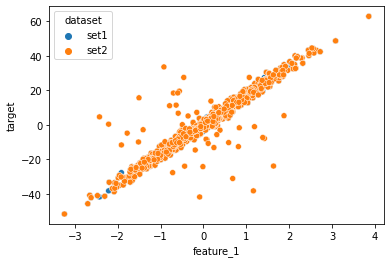

In [128]:
df_outlier = generate_outliers(df,['target'], percentage = 0.05, extreme_outlier = False)
sns.scatterplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_outlier.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

Observamos que el score de la regresion con mayor cantidad de outliers se ve afectada considerablemente

In [129]:
lineal_fit(df_outlier,columnas_a_modificar)

0.8763420818375557

## Ejercicio 5

Generar ahora valores extremos utilizando `extreme_outliers`. ¿Cómo afecta esto a la regresión? ¿Se observa algo interesante?


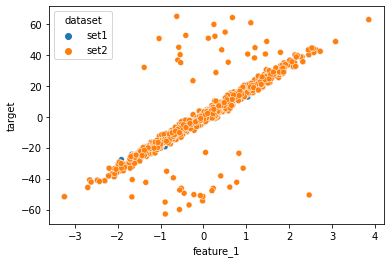

In [126]:
df_outlier_ext = generate_outliers(df,['target'], percentage = 0.05, extreme_outlier = True)
sns.scatterplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_outlier_ext.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

Ahora implementando los outliers extremos vemos que el score de la regresion cae mucho incluso con solo 5% de outliers

In [127]:
lineal_fit(df_outlier_ext,columnas_a_modificar)

0.7212476916499758

## Ejercicio 6

utilizando el archivo CSV `clase3v2.csv`, vamos a cargarlo como dataframe y deberemos:
 - Generar splits de training/test
 - Limpiar/Imputar datos Nulos
 - Entrenar un modelo de regresión multivariada
 - Reportar $R^2$ en test.

In [69]:
url='https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/intro_ia/cohorte-7/tp_enunciado/data/clase3v2.csv'
data_happiness = pd.read_csv(url, delimiter = ';')
data_happiness.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target_value
0,3.669506,2.863605,NaN,2.948632,NaN,-9.364512,7.564543
1,13.505001,4.482330,NaN,0.770769,NaN,-3.706287,32.866898
2,-5.736774,-1.030994,NaN,0.907981,NaN,5.332656,-20.922094
3,-0.019325,1.909841,NaN,0.137427,NaN,3.400036,1.433380
4,6.079670,1.528345,NaN,0.746475,NaN,-11.486688,11.867943


In [70]:
X_train, X_test,Y_train,Y_test = train_test_split(data_happiness.iloc[:,:6],data_happiness.iloc[:,6], train_size=0.8, random_state=42)

In [71]:
X_train_imputado = median_imputer(X_train,['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6'])
X_test_imputado = median_imputer(X_test,['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6'])


In [72]:
X_train_imputado.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
55,-2.800081,-3.078380,8.085855,0.594078,-3.779044,-13.355980
88,-1.131554,6.828352,-3.054384,-0.083569,1.833107,2.627744
26,2.426831,-1.556721,2.048743,-0.573126,-2.427306,-6.137065
42,14.724680,1.526057,11.733783,0.610179,3.362755,-2.774163
69,10.275338,-0.373827,2.353709,0.491020,-4.655846,-15.575730


In [73]:
X_test_imputado.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
83,5.787869,1.574225,-1.761402,1.803514,-0.333389,-4.628609
53,4.878929,-3.071783,-0.379464,-1.295139,-4.517666,-16.585686
70,3.604312,0.972712,10.329432,2.355838,0.250721,4.744813
45,14.563636,5.089565,1.852649,0.852823,2.123957,-7.130408
44,15.570838,2.680708,6.511630,1.523699,-0.416795,-9.408145


In [74]:
lr_multiple = linear_model.LinearRegression()

In [75]:
lr_multiple.fit(X_train_imputado, Y_train)

LinearRegression()

In [76]:
Y_pred_multiple = lr_multiple.predict(X_test_imputado)

In [77]:
from sklearn.metrics import r2_score
print('R²: %.2f' % r2_score(Y_test, Y_pred_multiple))

R²: 0.83


## Ejercicio 7

Por último, manteniendo un dataset limpio como el que generamos previo al ejercio 1, utilizando `make_regression` de `scikit-learn`. Analizar que pasa si comenzamos a modificar el parametro `noise`

Al aumentar la cantidad de noise podemos ver una mayor dispersion en los
datos de target, el parametro R2 va cayendo ya que cada vez el modelo se ajusta
menos a una funcion lineal

0.3668226998586082 0.05226653082419386


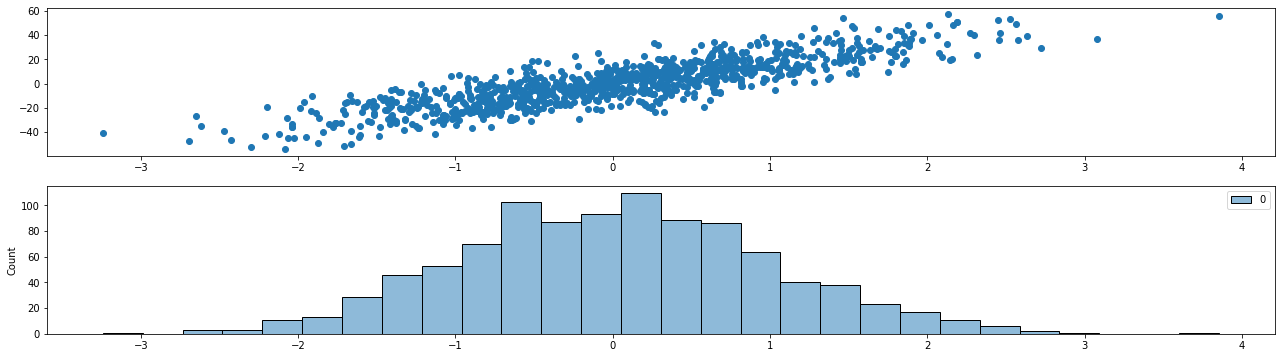

In [130]:

X_7, y_7 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 10,
                       n_informative = 1,
                       random_state = 42)

new_data_7 = np.append(X_7,y_7.reshape(-1,1),axis=1)
new_data_7.shape
df_7 = pd.DataFrame(new_data_7)

new_col = []
i = 0
for col in df_7.columns:
    if i ==  len(df_7.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df_7.columns = new_col

fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X_7,y_7)
sns.histplot(X_7, ax=axes[1]);

median_7=df_7.target.median()
mean_7=df_7.target.mean()
print(mean_7, median_7)

In [131]:
X_train_7, X_test_7,Y_train_7, Y_test_7 = train_test_split(df_7['feature_1'],df_7['target'],train_size=0.8,random_state=42)

In [132]:
linear_simple = linear_model.LinearRegression()
X_train_T=np.expand_dims(X_train_7.to_numpy(),axis=0)
X_train_T=X_train_T.reshape(-1,1)
X_test_T=np.expand_dims(X_test_7.to_numpy(),axis=0)
X_test_T=X_test_T.reshape(-1,1)
Y_train_T=np.expand_dims(Y_train_7.to_numpy(),axis=0)
Y_train_T=Y_train_T.reshape(-1,1)
Y_test_T=np.expand_dims(Y_test_7.to_numpy(),axis=0)
Y_test_T=Y_test_T.reshape(-1,1)
linear_simple.fit(X_train_T,Y_train_T)

LinearRegression()

In [133]:
Y_pred_T = linear_simple.predict(X_test_T)

In [134]:
print('R²: %.2f' % r2_score(Y_test_T, Y_pred_T))

R²: 0.72


# Segunda parte


## Ejercicio 8

Vamos a tomar dos dataframes creados uno en el ejercicio 4 y otro del 5, utilizando el modelo `HuberRegressor` en `linear_model` de `scikit-learn`. Vamos a entrenar dos modelos robustos, el modelo mejora?

***Nota:*** Utilizar los valores por defecto del modelo

In [142]:
huber = linear_model.HuberRegressor()
X_train_8, X_test_8,Y_train_8, Y_test_8 = train_test_split(df_outlier_ext['feature_1'],df_outlier_ext['target'],train_size=0.8,random_state=42)
#df_outlier
#df_outlier_ext


In [160]:
#X_train_8=np.expand_dims(X_train_8.to_numpy(),axis=0)
X_train_8=np.asarray(X_train_8).reshape(-1,1)
#X_test_8=np.expand_dims(X_test_8.to_numpy(),axis=0)
X_test_8=np.asarray(X_test_8).reshape(-1,1)
#Y_train_8=np.expand_dims(Y_train_8.to_numpy(),axis=0)
Y_train_8=np.asarray(Y_train_8).reshape(-1,1).flatten()
#Y_test_8=np.expand_dims(Y_test_8.to_numpy(),axis=0)
Y_test_8=np.asarray(Y_test_8).reshape(-1,1)#.flatten()
print(X_train_8.shape,Y_train_8.shape,X_test_8.shape,Y_test_8.shape)
huber.fit(X_train_8,Y_train_8)
linear_simple.fit(X_train_8,Y_train_8)

(800, 1) (800,) (200, 1) (200, 1)


LinearRegression()

In [161]:
Y_pred_8 = huber.predict(X_test_8)
Y_pred_8_L = linear_simple.predict(X_test_8)

In [165]:
print('Huber R²: %.2f' % r2_score(Y_test_8, Y_pred_8))
print('Linear R²: %.2f' % r2_score(Y_test_8, Y_pred_8_L))

Huber R²: 0.75
Linear R²: 0.75


## Ejercicio 9 (Opcional)

Utilizando este esta funcion de Gradiente descendente de como idea, codear su implementación de Sthocastic Gradient Descent (SGD)

```python

def ssr_gradient(x, y, b):
    res = b[0] + b[1] * x - y
    return res.mean(), (res * x).mean()

def gradient_descent(
    x: list,
    y: list,
    start: list,
    learn_rate: float = 0.1,
    n_iter: int = 50,
    tolerance: float =1e-06
):
    vector = start
    for _ in range(n_iter):
        diff = -learn_rate * np.array(ssr_gradient(x, y, vector))
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
    return vector
```

# Tercera Parte

Vamos a crear un nuevo dataset, para ello vamos a usar el metodo `make_classification` de `sklearn`

In [166]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

X_10, y_10 = make_classification(
    n_samples = 1000,
    n_features=3,
    n_redundant=0,
    n_informative=3,
    random_state=42,
    n_classes=2,
    n_clusters_per_class=3
)

In [167]:
new_data_10 = np.append(X_10,y_10.reshape(-1,1),axis=1)
new_data_10.shape
df_10 = pd.DataFrame(new_data_10)

new_col = []
i = 0
for col in df_10.columns:
    if i ==  len(df_10.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df_10.columns = new_col
df_10.head()

,feature_1,feature_2,feature_3,target
0,0.948171,0.952130,-1.200182,1.0
1,1.288362,0.330222,1.026760,1.0
2,0.928280,0.927720,-1.246460,1.0
3,0.460683,-1.397768,-0.616106,1.0
4,-1.402125,-0.943615,-0.297036,0.0


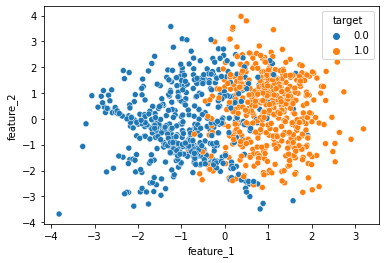

In [89]:
sns.scatterplot(data = df_10,
                x = 'feature_1',
                y = 'feature_2',
                hue = 'target')

In [90]:
X_train_10, X_test_10,Y_train_10, Y_test_10 = train_test_split(df_10.iloc[:,0:-1],df_10.iloc[:,-1],train_size=0.8,random_state=42)

## Ejercicio 10

Con el dataset creado para clasficación vamos a utilizar el modelo `LogisticRegression`. Vamos a entrenar modelos variando los parámetros en particular `tol` y `max_iter`.
¿Cómo cambian estas regresiones?

Si variamos la cantidad de features del dataset podemos observar que las iteraciones necesarias para que converja la regresion logistica va a variar, aumentando en algunos casos y disminuyendo en otros, en conjunto con la tolerancia definida. Sin embargo el modelo logistico es muy robusto, logrando una accuracy alta en cualquiera de los casos presentados.


In [168]:
log1=linear_model.LogisticRegression(tol=0.0001,max_iter=15)
log1.fit(X_train_10,Y_train_10)
Y_pred_10=log1.predict(X_test_10)
print('Logistic R²: %.2f' % log1.score(X_test_10, Y_pred_10))

Logistic R²: 1.00


In [169]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
confusion_matrix(Y_test_10,Y_pred_10),accuracy_score(Y_test_10,Y_pred_10),precision_score(Y_test_10,Y_pred_10),recall_score(Y_test_10,Y_pred_10)

(array([[93, 14],
        [ 2, 91]]), 0.92, 0.8666666666666667, 0.978494623655914)

In [170]:
log1.n_iter_

array([11], dtype=int32)

In [171]:
log2=linear_model.LogisticRegression(tol=0.1,max_iter=12)
log2.fit(X_train_10,Y_train_10)
Y_pred_10=log2.predict(X_test_10)
print('Logistic score: %.2f' % log2.score(X_test_10, Y_pred_10))

Logistic score: 1.00


In [172]:
log2.n_iter_

array([10], dtype=int32)

In [173]:
confusion_matrix(Y_test_10,Y_pred_10),accuracy_score(Y_test_10,Y_pred_10),precision_score(Y_test_10,Y_pred_10),recall_score(Y_test_10,Y_pred_10)

(array([[93, 14],
        [ 2, 91]]), 0.92, 0.8666666666666667, 0.978494623655914)

In [174]:
log3=linear_model.LogisticRegression(tol=0.5,max_iter=200)
log3.fit(X_train_10,Y_train_10)
Y_pred_10=log3.predict(X_test_10)
print('Logistic score: %.2f' % log3.score(X_test_10, Y_pred_10))

Logistic score: 1.00


In [175]:
confusion_matrix(Y_test_10,Y_pred_10),accuracy_score(Y_test_10,Y_pred_10),precision_score(Y_test_10,Y_pred_10),recall_score(Y_test_10,Y_pred_10)

(array([[93, 14],
        [ 2, 91]]), 0.92, 0.8666666666666667, 0.978494623655914)

In [176]:
log4=linear_model.LogisticRegression(tol=0.001,max_iter=250)
log4.fit(X_train_10,Y_train_10)
Y_pred_10=log4.predict(X_test_10)
print('Logistic score: %.2f' % log4.score(X_test_10, Y_pred_10))

Logistic score: 1.00


In [177]:
confusion_matrix(Y_test_10,Y_pred_10),accuracy_score(Y_test_10,Y_pred_10),precision_score(Y_test_10,Y_pred_10),recall_score(Y_test_10,Y_pred_10)

(array([[93, 14],
        [ 2, 91]]), 0.92, 0.8666666666666667, 0.978494623655914)

## Ejercicio 11

Vamos a utilizar ahora el dataset de [iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Utilizando `LogisticRegression` vamos a realizar un clasificador multiclases.
¿Cómo se compara con el modelo de `Perceptron`?

Analizando las metricas de Accuracy, Precission y Recall, que podemos obtener a partir de la matriz de confusion, encontramos que el perceptron es bueno pero el regresor logistico es mejor para este caso. En el caso de la segunda clase el perceptron solo acerto 3 de 9 predicciones, y el regresor logistico acerto todos.

In [178]:
from sklearn.datasets import load_iris
X,y = load_iris(return_X_y=True, as_frame=True)

HINT: La clase perceptron la pueden utilizar así

```python
from sklearn.linear_model import Perceptron
X, y = load_iris(return_X_y=True, as_frame=True)
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X, y)

clf.score(X, y)
```

In [179]:
from sklearn.linear_model import Perceptron
X, y = load_iris(return_X_y=True, as_frame=True)
clf = Perceptron(tol=1e-3, random_state=0)
X_train_11, X_test_11,Y_train_11, Y_test_11 = train_test_split(X,y,train_size=0.8,random_state=42)
clf.fit(X_train_11, Y_train_11)

#clf.score(X, y)

Perceptron()

In [181]:
Y_pred_11=clf.predict(X_test_11)

In [182]:
confusion_matrix(Y_test_11,Y_pred_11),accuracy_score(Y_test_11,Y_pred_11),precision_score(Y_test_11,Y_pred_11,average=None),recall_score(Y_test_11,Y_pred_11,average=None)

(array([[10,  0,  0],
        [ 6,  3,  0],
        [ 0,  0, 11]]),
 0.8,
 array([0.625, 1.   , 1.   ]),
 array([1.        , 0.33333333, 1.        ]))

In [183]:
log_perceptron=linear_model.LogisticRegression(max_iter=1000)

In [184]:
log_perceptron.fit(X_train_11, Y_train_11)

Y_pred_11 = log_perceptron.predict(X_test_11)

In [185]:
confusion_matrix(Y_test_11,Y_pred_11),accuracy_score(Y_test_11,Y_pred_11),precision_score(Y_test_11,Y_pred_11,average=None),recall_score(Y_test_11,Y_pred_11,average=None)

(array([[10,  0,  0],
        [ 0,  9,  0],
        [ 0,  0, 11]]), 1.0, array([1., 1., 1.]), array([1., 1., 1.]))